In [37]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, acf, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf,month_plot,quarter_plot
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline 
sns.set_style("whitegrid")
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 

In [38]:
data = pd.read_csv('SoleaTimeSeriesDataset-Temperature-Salinity.csv')
data['year_month'] = pd.to_datetime(data['year_month'])
data['year'] = data['year_month'].dt.year
data['month'] = data['year_month'].dt.month
data.head()

,id,obs_id,year_month,temperatureSurface,temperature100_300,temperature300_400,temperature100_500,temperatureMaxDepth,salinitySurface,salinity100_300,salinity300_400,salinity100_500,salinityMaxDepth,year,month
0,02008-01,0,2008-01-01,15.713940,13.886082,13.886082,13.088567,12.823628,37.147140,38.262170,38.262170,38.560493,38.584150,2008,1
1,02008-02,0,2008-02-01,14.792473,13.868667,13.868667,13.081740,12.822814,37.084457,38.264230,38.264230,38.563950,38.584694,2008,2
2,02008-03,0,2008-03-01,14.733397,13.963535,13.963535,13.082810,12.824340,36.935814,38.210846,38.210846,38.561314,38.586860,2008,3
3,02008-04,0,2008-04-01,15.850550,13.979778,13.979778,13.139173,12.829004,37.155983,38.196102,38.196102,38.553448,38.589336,2008,4
4,02008-05,0,2008-05-01,18.497694,13.637879,13.637879,13.128523,12.827576,37.341560,38.253180,38.253180,38.548040,38.588478,2008,5


### Time Plot

For time series data, the obvious graph to start with is a time plot. That is, the observations are plotted against the time of observation, with consecutive observations joined by straight lines. 

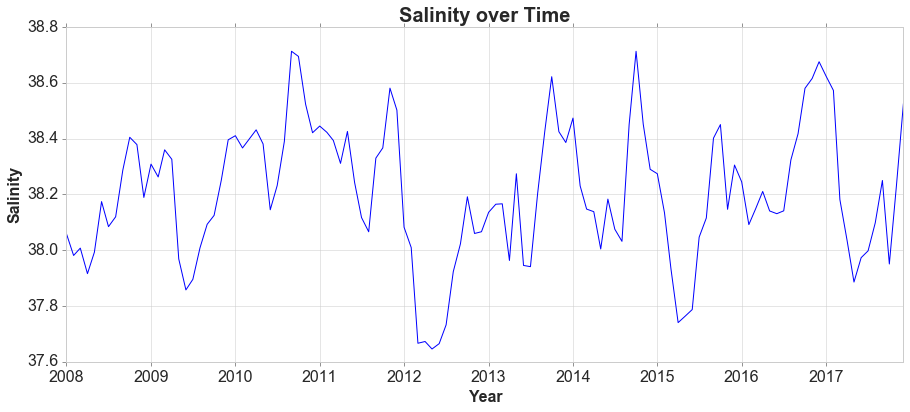

In [39]:
fig, ax = plt.subplots(figsize=(15, 6))
d = data[data['obs_id']==2]
sns.lineplot(d['year_month'], d['salinitySurface'] )

ax.set_title('Salinity over Time', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Salinity', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
ax.yaxis.tick_left() # where the y axis marks will be

The monthly data show strong seasonality within each year. There is no cyclic behavior and no trend.

### Seasonal Plot and Box Plots

A seasonal plot is similar to a time plot except that the data are plotted against the individual “seasons” in which the data were observed. 

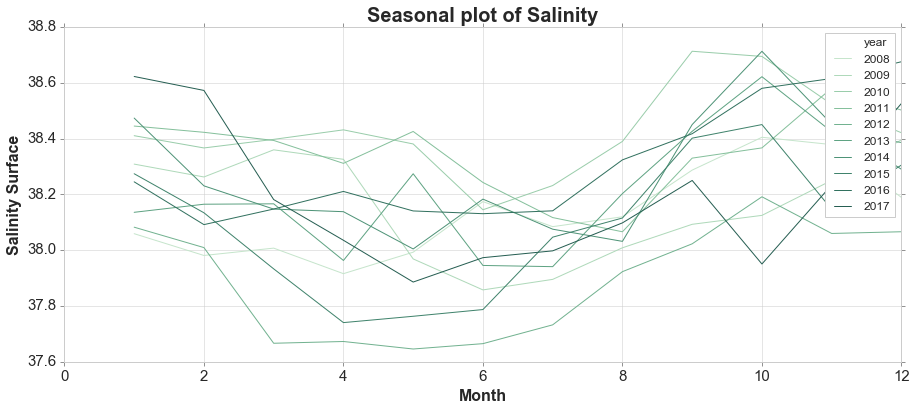

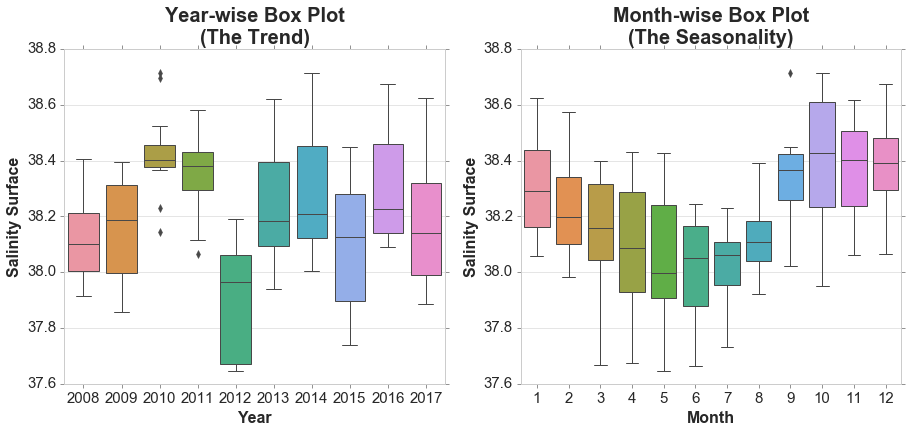

In [40]:
variable = 'salinitySurface'
fig, ax = plt.subplots(figsize=(15, 6))

palette = sns.color_palette("ch:2.5,-.2,dark=.3", 10)
sns.lineplot(d['month'], d[variable], hue=d['year'], palette=palette)
ax.set_title('Seasonal plot of Salinity', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Salinity Surface', fontsize = 16, fontdict=dict(weight='bold'))


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

sns.boxplot(d['year'], d[variable], ax=ax[0])
ax[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[0].set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax[0].set_ylabel('Salinity Surface', fontsize = 16, fontdict=dict(weight='bold'))

sns.boxplot(d['month'], d[variable], ax=ax[1])
ax[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[1].set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax[1].set_ylabel('Salinity Surface', fontsize = 16, fontdict=dict(weight='bold'))

### Seasonal Subseries Plots

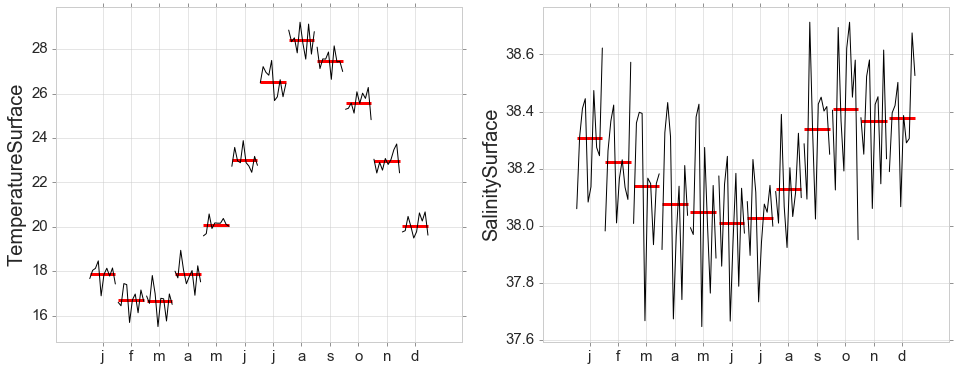

In [55]:
y = data[data['obs_id']==2][['year_month','temperatureSurface','salinitySurface']]
y = y.set_index('year_month')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
month_plot(y['temperatureSurface'],ylabel='TemperatureSurface', ax=ax[0]);
month_plot(y['salinitySurface'],ylabel='SalinitySurface', ax=ax[1]);

### Decomposition

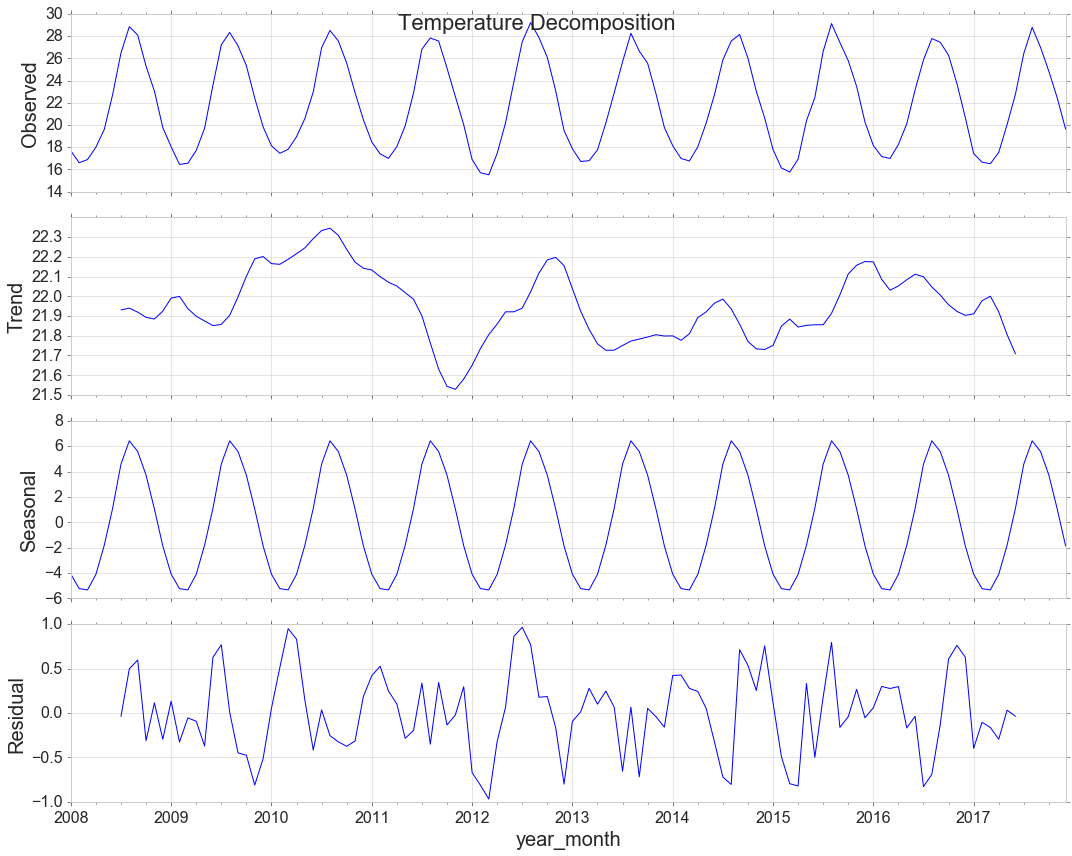

In [21]:
y = data[data['obs_id']==2][['year_month','temperatureSurface']]
y = y.set_index('year_month')

from pylab import rcParams
rcParams['figure.figsize'] = 15, 12
rcParams['axes.labelsize'] = 20
rcParams['ytick.labelsize'] = 16
rcParams['xtick.labelsize'] = 16
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
decomp = decomposition.plot()
decomp.suptitle('Temperature Decomposition', fontsize=22)

The Hodrick-Prescott filter separates a time-series yt into a trend component τ and a cyclical component ct. For monthly data lambda=129,600.

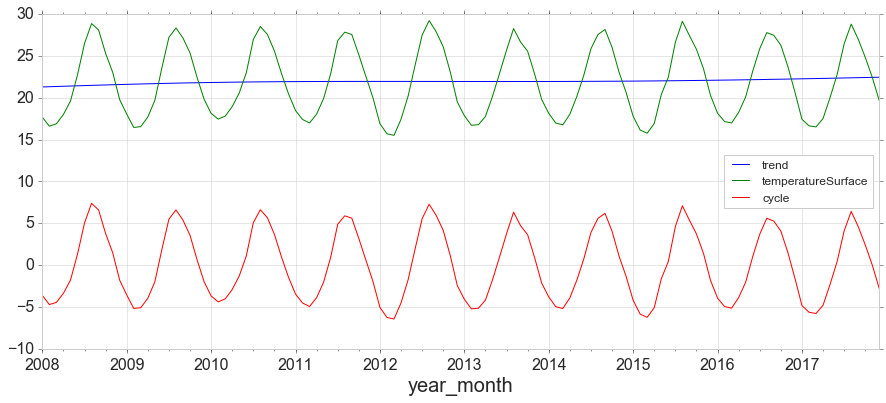

In [22]:
from statsmodels.tsa.filters.hp_filter import hpfilter

gdp_cycle, gdp_trend = hpfilter(y['temperatureSurface'], lamb=129600)
y['trend'] = gdp_trend
y['cycle'] = gdp_cycle

y[['trend','temperatureSurface','cycle']].plot(figsize=(15,6)).autoscale(axis='x',tight=True);

### Measure the strength of trend. 0 for low, 1 for high

In [23]:
max(0,(1-decomposition.resid.var()/(decomposition.resid+decomposition.trend).var())[0])

0.10248782084731933

### Measure the strength of seasonality

In [24]:
max(0,(1-decomposition.resid.var()/(decomposition.resid+decomposition.seasonal).var())[0])

0.9880830435213952

### Detrend

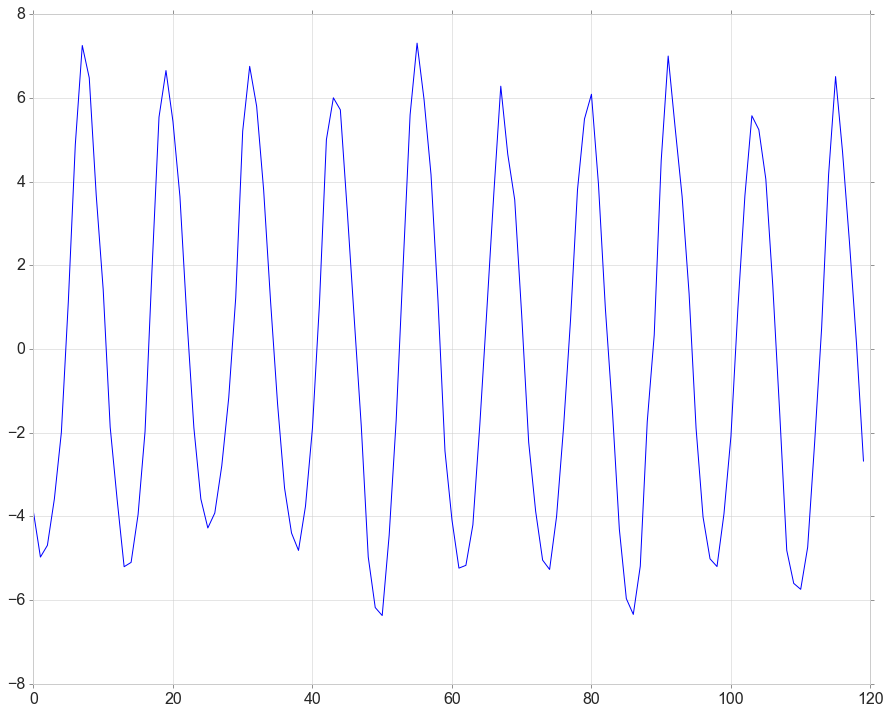

In [25]:
detrended = signal.detrend(data[data['obs_id']==2][['year_month','temperatureSurface']]['temperatureSurface'].values)
plt.plot(detrended)

### Stationarity

In [27]:
from statsmodels.tsa.stattools import adfuller
# check for stationarity
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print('Augmented Dickey-Fuller Test: {}'.format(title))
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out['critical value ({})'.format(key)]=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [29]:
adf_test(data[data['obs_id']==2][['year_month','temperatureSurface']]['temperatureSurface'],title='')

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.864219
p-value                   0.049670
# lags used              10.000000
# observations          109.000000
critical value (5%)      -2.888444
critical value (1%)      -3.491818
critical value (10%)     -2.581120
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [30]:
# KPSS Test
result = kpss(data[data['obs_id']==2][['year_month','temperatureSurface']]['temperatureSurface'].values, regression='c')
print("\nKPSS Statistic: {}".format(result[0]))
print("P-Value: {}".format(result[1]))
for key, value in result[3].items():
    print('Critial Values:')
    print("   {}, {}".format(key,value))


KPSS Statistic: 0.16268094415564427
P-Value: 0.1
Critial Values:
   5%, 0.463
Critial Values:
   1%, 0.739
Critial Values:
   2.5%, 0.574
Critial Values:
   10%, 0.347


c:\users\jim\appdata\local\programs\python\python35\lib\site-packages\statsmodels\tsa\stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In the ADF test, the null hypothesis is the time series possesses a unit root and is non-stationary. So because the P-Value is <0.05 we reject the null hypothesis.

The KPSS test, on the other hand, is used to test for trend stationarity. The null hypothesis and the P-Value interpretation is just the opposite of ADH test.

### Granger Causality Tests

Essentially we're looking for extremely low p-values.

In [35]:
grangercausalitytests(data[data['obs_id']==2][['temperatureSurface','salinitySurface']],maxlag=2);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=58.2046 , p=0.0000  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=59.7099 , p=0.0000  , df=1
likelihood ratio test: chi2=48.3902 , p=0.0000  , df=1
parameter F test:         F=58.2046 , p=0.0000  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5797  , p=0.2106  , df_denom=113, df_num=2
ssr based chi2 test:   chi2=3.2992  , p=0.1921  , df=2
likelihood ratio test: chi2=3.2539  , p=0.1965  , df=2
parameter F test:         F=1.5797  , p=0.2106  , df_denom=113, df_num=2


So, one time series is useful in forecasting the other.

### Autocorrelation

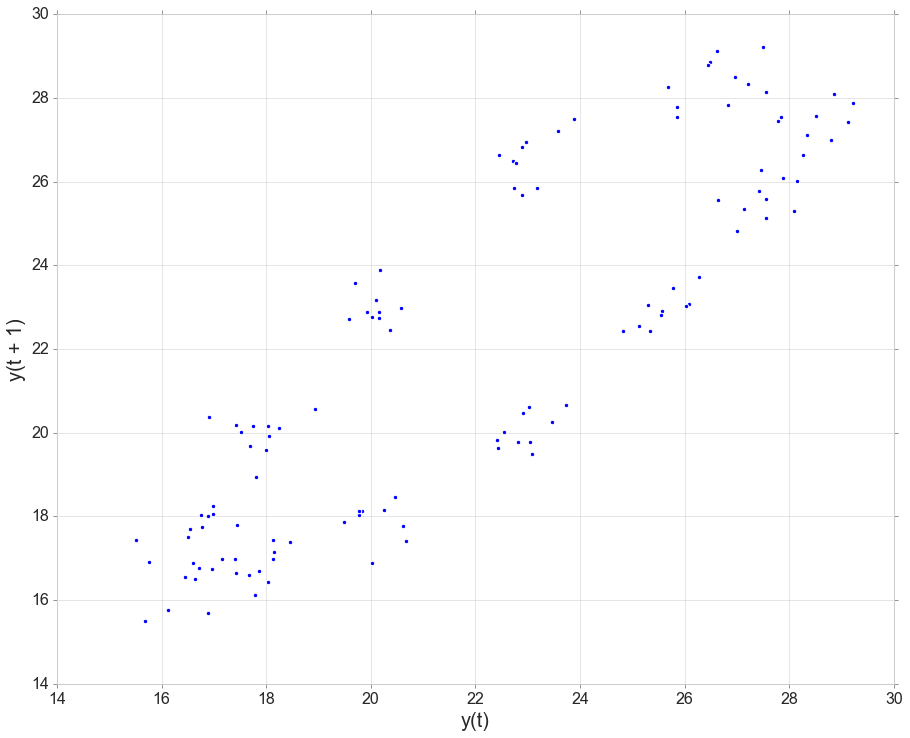

In [14]:
# Lag PLots
from pandas.plotting import lag_plot
lag_plot(data[data['obs_id']==2]['temperatureSurface']);

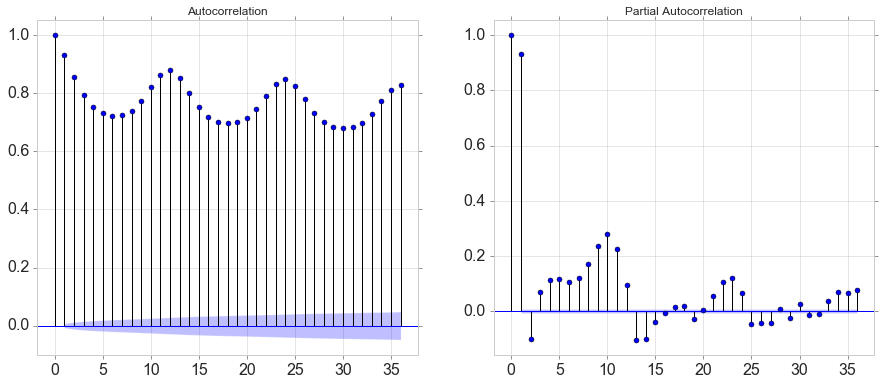

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15, 6))
#autocorr = acf(data[variable], nlags=12) # just the numbers
plot_acf(data[variable].tolist(), lags=36, ax=ax[0]); # just the plot
plot_pacf(data[variable].tolist(), lags=36, ax=ax[1]); # just the plot

In [59]:
autocorr

array([1.        , 0.9326662 , 0.85668922, 0.79436762, 0.75302265,
       0.73118683, 0.72281034, 0.72513455, 0.74072217, 0.77355728,
       0.82080037, 0.86408744, 0.88016387])

### Simple Moving Average, expanding and Exponentially Weighted Moving Average

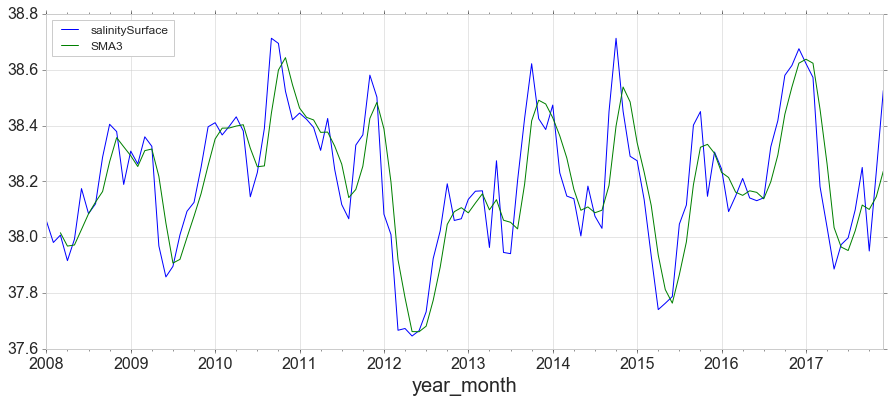

In [197]:
y = data[data['obs_id']==2][['year_month','salinitySurface']]
y = y.set_index('year_month')
y['SMA3'] = y.rolling(window=3).mean() 
y.plot(figsize=(15,6));

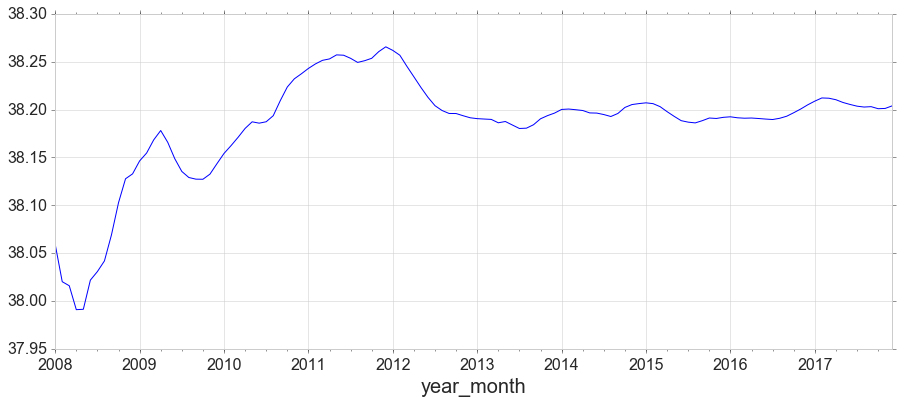

In [168]:
y1 = data[data['obs_id']==2][['year_month','salinitySurface']]
y1 = y1.set_index('year_month')
y1['salinitySurface'].expanding().mean().plot(figsize=(15,6));

In [198]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

span = 3
alpha = 2/(span+1)
y.index.freq = 'MS'
y['SES3']=SimpleExpSmoothing(y['salinitySurface']).fit(smoothing_level=alpha,optimized=False).fittedvalues
y.head()

,salinitySurface,SMA3,SES3
year_month,,,
2008-01-01,38.059185,NaN,38.059185
2008-02-01,37.981125,NaN,38.059185
2008-03-01,38.007427,38.015912,38.020155
2008-04-01,37.915913,37.968155,38.013791
2008-05-01,37.992910,37.972083,37.964852


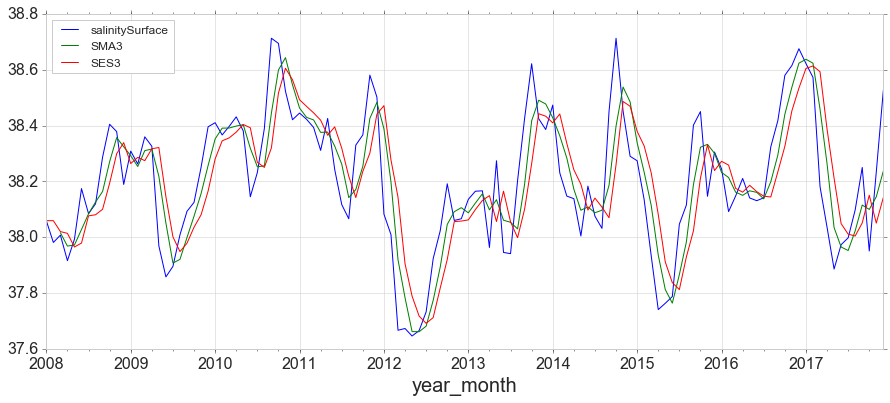

In [199]:
y.plot(figsize=(15,6));

### Double Exponential Smoothing
Where Simple Exponential Smoothing employs just one smoothing factor $\alpha$ (alpha), Double Exponential Smoothing adds a second smoothing factor $\beta$ (beta) that addresses trends in the data. Like the alpha factor, values for the beta factor fall between zero and one ($0<\beta≤1$). The benefit here is that the model can anticipate future increases or decreases where the level model would only work from recent calculations.

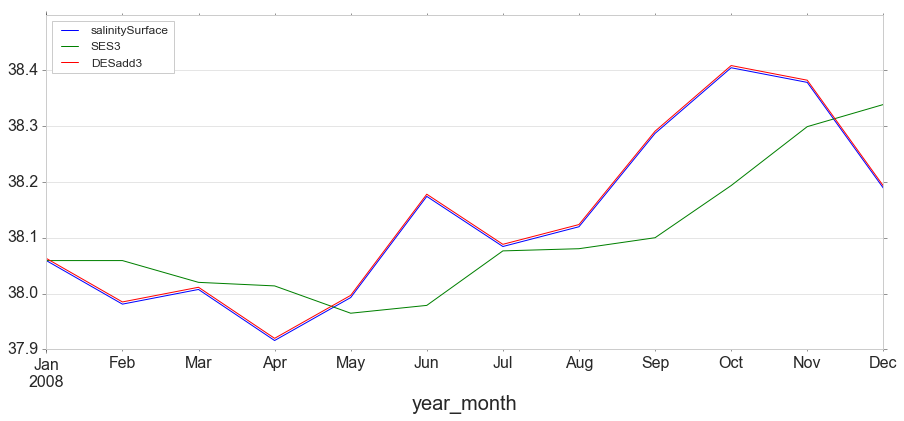

In [200]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

y['DESadd3'] = ExponentialSmoothing(y['salinitySurface'], trend='add').fit().fittedvalues.shift(-1)
y[['salinitySurface', 'SES3', 'DESadd3']].iloc[:12].plot(figsize=(15,6));

### Triple Exponential Smoothing
Triple Exponential Smoothing, the method most closely associated with Holt-Winters, adds support for both trends and seasonality in the data. 

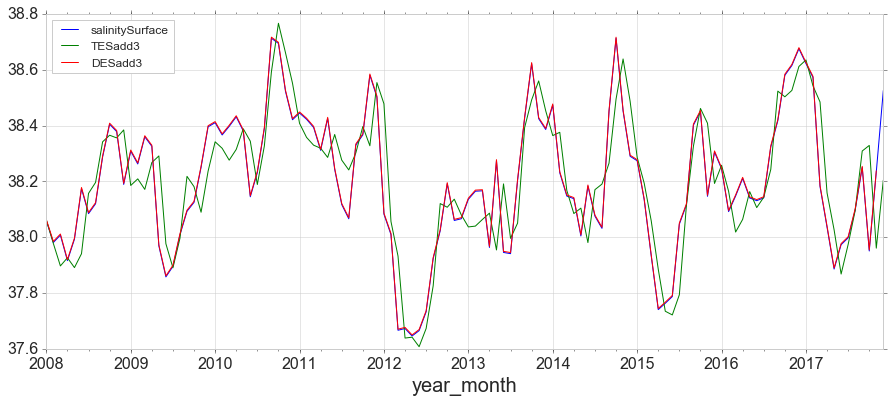

In [203]:
y['TESadd3'] = ExponentialSmoothing(y['salinitySurface'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
y[['salinitySurface', 'TESadd3', 'DESadd3']].plot(figsize=(15,6));

### Simple forecasting methods

#### Average method
Here, the forecasts of all future values are equal to the mean of the historical data.

#### Naïve method
For naïve forecasts, we simply set all forecasts to be the value of the last observation.

#### Seasonal naïve method
In this case, we set each forecast to be equal to the last observed value from the same season of the year.

#### Drift method
A variation on the naïve method is to allow the forecasts to increase or decrease over time, where the amount of change over time (called the drift) is set to be the average change seen in the historical data.